## Fine tuning the inception v3 on custom dataset

In [1]:
# Dataset
# A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:

# 0 - No DR
# 1 - Mild
# 2 - Moderate
# 3 - Severe
# 4 - Proliferative DR

In [2]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
!unzip  /content/drive/MyDrive/Diabetic_retinopathy/sample.zip

Archive:  /content/drive/MyDrive/Diabetic_retinopathy/sample.zip
   creating: sample/
  inflating: sample/10_left.jpeg     
  inflating: sample/10_right.jpeg    
  inflating: sample/13_left.jpeg     
  inflating: sample/13_right.jpeg    
  inflating: sample/15_left.jpeg     
  inflating: sample/15_right.jpeg    
  inflating: sample/16_left.jpeg     
  inflating: sample/16_right.jpeg    
  inflating: sample/17_left.jpeg     
  inflating: sample/17_right.jpeg    


In [8]:
!unzip  /content/drive/MyDrive/Diabetic_retinopathy/trainLabels.csv.zip

Archive:  /content/drive/MyDrive/Diabetic_retinopathy/trainLabels.csv.zip
  inflating: trainLabels.csv         


In [ ]:
# !unzip /content/drive/MyDrive/Diabetic_retinopathy/resized_train.zip
!unzip /content/drive/MyDrive/Diabetic_retinopathy/resized_train_cropped.zip

In [10]:
!ls

drive  resized_train_cropped  sample  sample_data  trainLabels.csv


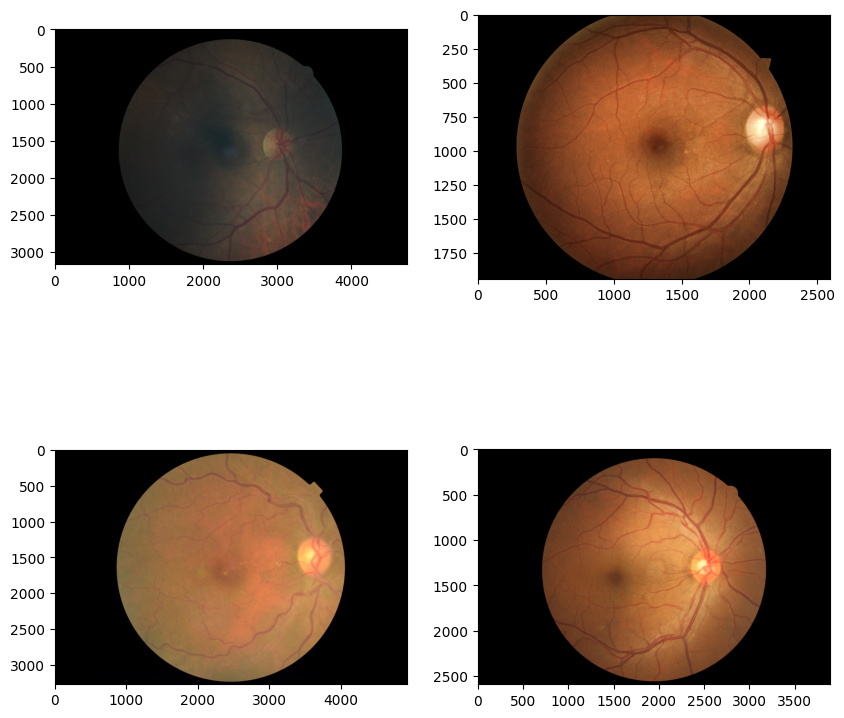

In [11]:
f, axarr = plt.subplots(2,2, figsize=(10, 10))
axarr[0,0].imshow(Image.open("sample/10_right.jpeg"))
axarr[0,1].imshow(Image.open("sample/13_right.jpeg"))
axarr[1,0].imshow(Image.open("sample/15_right.jpeg"))
axarr[1,1].imshow(Image.open("sample/17_right.jpeg"))

In [12]:
df = pd.read_csv("trainLabels.csv")
df.shape

(35126, 2)

NUM DATA : 5000
NUM CLASSES : 5
CLASS DIST : [3657, 354, 788, 108, 93]


<BarContainer object of 5 artists>

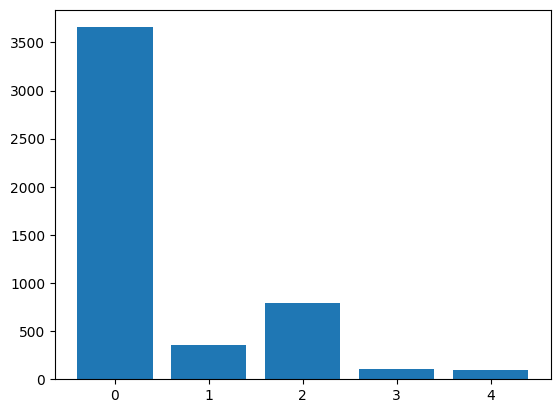

In [13]:
df = pd.read_csv("trainLabels.csv")[:5000]
df['image'] = df['image'].apply(lambda x: "resized_train_cropped/" + x + ".jpeg")
df.head()
num_classes = len(np.unique(df['level']))
class_dist = [len(df.loc[df['level'] == x]) for x in range(num_classes)]

print(f"NUM DATA : {len(df)}")
print(f"NUM CLASSES : {num_classes}")
print(f"CLASS DIST : {class_dist}")
plt.bar(np.unique(df['level']), class_dist)

In [14]:
df_all = pd.read_csv("trainLabels.csv")
df_all.shape

(35126, 2)

In [15]:
df_all.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


<Axes: >

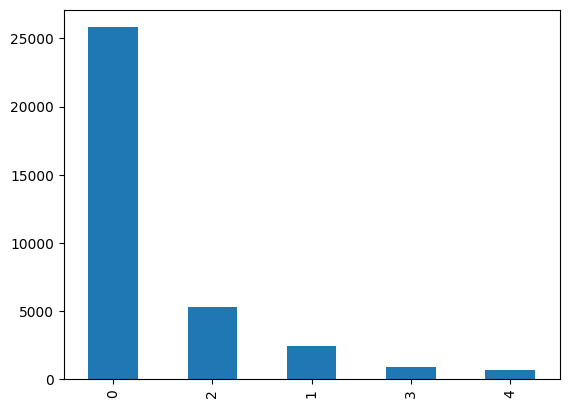

In [16]:
# Major imbalance in the dataset
df_all["level"].value_counts().plot.bar()

In [17]:
df_all["level"].value_counts(normalize=True)

0    0.734783
2    0.150658
1    0.069550
3    0.024853
4    0.020156
Name: level, dtype: float64

In [18]:
#sample image - large dimensions of images, all images of size 4752. 3168
sample_image = Image.open("sample/10_right.jpeg")
sample_image.size

(4752, 3168)

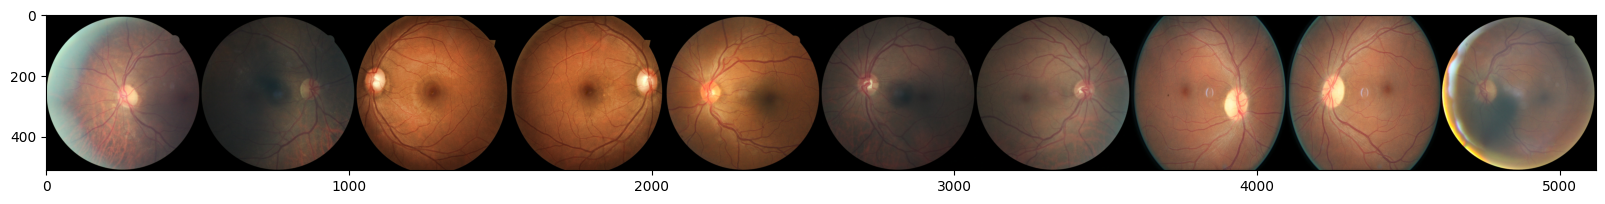

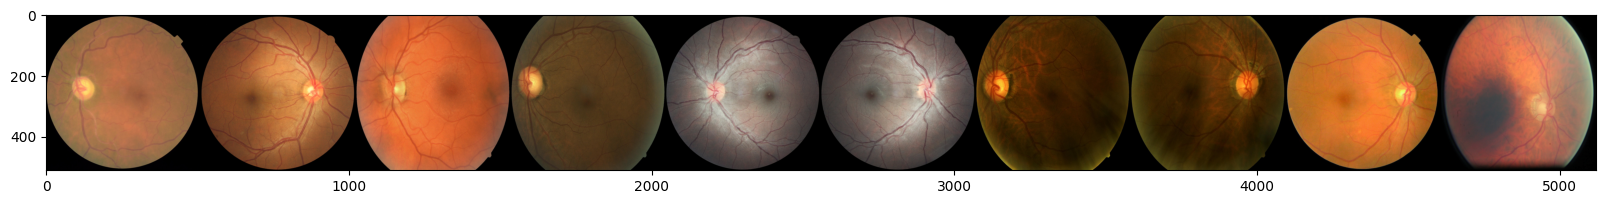

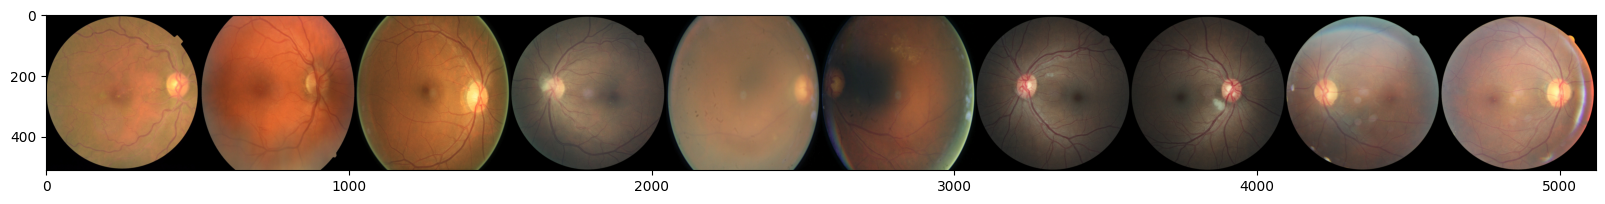

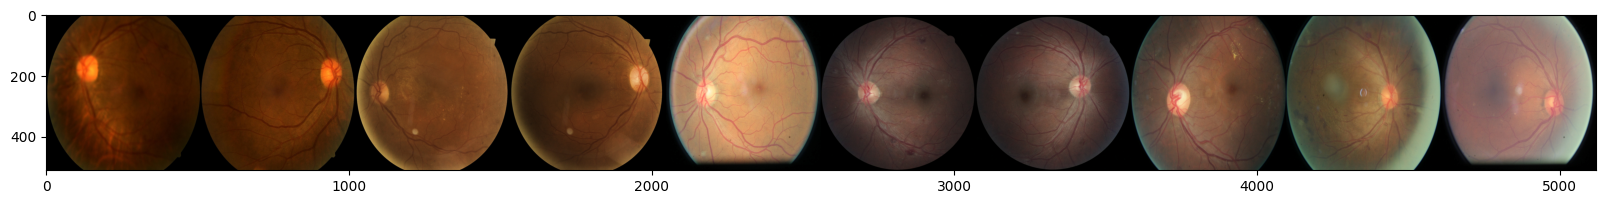

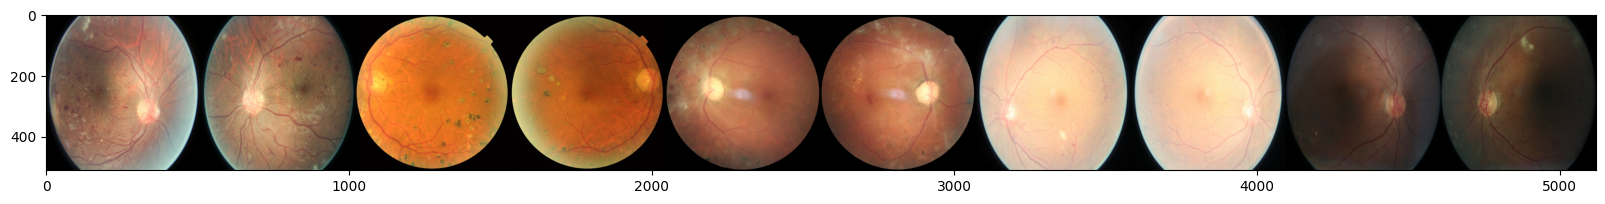

In [19]:
# visualize
def visualize_image_per_level(level=0):
    level_images = df.loc[df['level'] == level]['image'].values
    # IMG_DIR = "resized_train/resized_train/"
    images = []
    for i in range(10):
        img = Image.open(level_images[i])
        img = img.resize((512, 512))
        images.append(np.array(img))
    images = np.concatenate(images, axis=1)
    plt.figure(figsize=(20, 40))
    plt.imshow(images)

for c in range(num_classes):
    visualize_image_per_level(c)

## Construct Dataset

In [20]:
df

,image,level
0,resized_train_cropped/10_left.jpeg,0
1,resized_train_cropped/10_right.jpeg,0
2,resized_train_cropped/13_left.jpeg,0
3,resized_train_cropped/13_right.jpeg,0
4,resized_train_cropped/15_left.jpeg,1
...,...,...
4995,resized_train_cropped/6291_right.jpeg,0
4996,resized_train_cropped/6298_left.jpeg,0
4997,resized_train_cropped/6298_right.jpeg,0
4998,resized_train_cropped/6299_left.jpeg,2


In [21]:
df['image'].values

array(['resized_train_cropped/10_left.jpeg',
       'resized_train_cropped/10_right.jpeg',
       'resized_train_cropped/13_left.jpeg', ...,
       'resized_train_cropped/6298_right.jpeg',
       'resized_train_cropped/6299_left.jpeg',
       'resized_train_cropped/6299_right.jpeg'], dtype=object)

In [22]:
# Taking only the first 1000 images
def examine_files(files, labels):
    confirmed_files = []
    confirmed_labels = []
    for i in range(len(files)):
        if os.path.isfile(files[i]):
            confirmed_files.append(files[i])
            confirmed_labels.append(labels[i])
    return confirmed_files, np.array(confirmed_labels)

# train / val /test split
total_files = df['image'].values
total_labels = df['level'].values


# data scarcity setting
total_files = total_files[:5000]
total_labels = total_labels[:5000]

unlabeled_files = total_files[5000:]
unlabeled_labels = total_labels[5000:]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
remained_idx, test_idx = next(sss.split(total_files, total_labels))
remained_files = total_files[remained_idx]
remained_labels = total_labels[remained_idx]

test_files = total_files[test_idx]
test_labels = total_labels[test_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_idx, val_idx = next(sss.split(remained_files, remained_labels))
train_files = remained_files[train_idx]
train_labels = remained_labels[train_idx]

val_files = remained_files[val_idx]
val_labels = remained_labels[val_idx]

train_files, train_labels = examine_files(train_files, train_labels)
val_files, val_labels = examine_files(val_files, val_labels)
test_files, test_labels = examine_files(test_files, test_labels)

train_df = pd.DataFrame(data={'image': train_files, 'level': train_labels})
val_df = pd.DataFrame(data={'image': val_files, 'level': val_labels})
test_df = pd.DataFrame(data={'image': test_files, 'level': test_labels})


# For each class train validate and test a certain number of samples
print(f"NUM TRAIN / VAL / TEST : {len(train_files)} / {len(val_files)} / {len(test_files)}")
for c in range(num_classes):
    print(f"NUM CLASS {c} TRAIN / VAL / TEST : {len(np.where(train_labels==c)[0])} / {len(np.where(val_labels==c)[0])} / {len(np.where(test_labels==c)[0])}")

NUM TRAIN / VAL / TEST : 3197 / 800 / 999
NUM CLASS 0 TRAIN / VAL / TEST : 2340 / 585 / 730
NUM CLASS 1 TRAIN / VAL / TEST : 225 / 57 / 71
NUM CLASS 2 TRAIN / VAL / TEST : 503 / 126 / 158
NUM CLASS 3 TRAIN / VAL / TEST : 70 / 17 / 21
NUM CLASS 4 TRAIN / VAL / TEST : 59 / 15 / 19


In [23]:
import torchvision.transforms as transforms
# resize to a higher dimension
my_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Pytorch dataloader
class retinaDataset(Dataset):
    def __init__(self, df,transform=my_transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = Image.open(self.df.iloc[index].image)

        if(self.transform):
            img = self.transform(img)

        return img, torch.tensor(self.df.iloc[index].level)

In [24]:
batch_size = 16

train_dataset = retinaDataset(train_df)
val_dataset = retinaDataset(val_df)
test_dataset = retinaDataset(test_df)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
train_dataset[1][0].shape

torch.Size([3, 299, 299])

In [26]:
train_dataset[1][1]

tensor(0)

## Model Build

In [27]:
from torchvision.models import inception_v3

learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = inception_v3(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
model.aux_logits = False
model = model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# model

In [29]:
# Make sure device is on cudab
device

device(type='cuda')

In [30]:
# from tqdm import tqdm

# def check_accuracy(model, loader):
#     model.eval()

#     correct_output = 0
#     total_output = 0

#     with torch.no_grad():
#         for x, y in tqdm(loader):
#             x = x.to(device=device)
#             y = y.to(device=device)

#             score = model(x)
#             _,predictions = score.max(1)

#             correct_output += (y==predictions).sum()
#             total_output += predictions.shape[0]
#     model.train()
#     print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")
#     return float(correct_output/total_output)*100

# num_epochs = 10
# best_score = 0
# for epoch in range(num_epochs):
#     for data, target in tqdm(train_dataloader):
#         data = data.to(device=device)
#         target = target.to(device=device)
#         print(data.shape)
#         score = model(data)
#         optimizer.zero_grad()

#         loss = loss_criterion(score, target)
#         loss.backward()

#         optimizer.step()

#     print(f"for epoch {epoch}, loss : {loss}")
#     val_acc = check_accuracy(model, val_dataloader)
#     if val_acc > best_score:
#         best_score = val_acc
#         torch.save(model.state_dict(), "/content/drive/MyDrive/Diabetic_retinopathy/best_model_2000.pt")

import torch
from tqdm import tqdm

def check_accuracy(model, loader, device):
    model.eval()

    correct_output = 0
    total_output = 0

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            score = model(x)
            _, predictions = score.max(1)

            correct_output += (y == predictions).sum().item()
            total_output += predictions.shape[0]

    accuracy = float(correct_output) / total_output * 100
    print(f"Out of {total_output}, total correct: {correct_output} with an accuracy of {accuracy}%")
    model.train()
    return accuracy

num_epochs = 10
best_score = 0
early_stopping_counter = 0
early_stopping_patience = 5  # Number of epochs to wait before stopping if no improvement

for epoch in range(num_epochs):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        score = model(data)
        optimizer.zero_grad()

        loss = loss_criterion(score, target)
        loss.backward()

        optimizer.step()

    print(f"For epoch {epoch}, loss: {loss.item()}")
    val_acc = check_accuracy(model, val_dataloader, device)
    if val_acc > best_score:
        best_score = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/Diabetic_retinopathy/best_model_5000.pt")
        print("Model saved as validation accuracy improved.")
        early_stopping_counter = 0  # reset the counter if performance improved
    else:
        early_stopping_counter += 1
        print(f"Validation accuracy did not improve for {early_stopping_counter} epoch(s).")

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break


100%|██████████| 199/199 [00:57<00:00,  3.47it/s]


For epoch 0, loss: 0.8483115434646606


100%|██████████| 50/50 [00:12<00:00,  4.06it/s]


Out of 800, total correct: 593 with an accuracy of 74.125%
Model saved as validation accuracy improved.


100%|██████████| 199/199 [00:54<00:00,  3.66it/s]


For epoch 1, loss: 0.5524924993515015


100%|██████████| 50/50 [00:12<00:00,  4.05it/s]


Out of 800, total correct: 576 with an accuracy of 72.0%
Validation accuracy did not improve for 1 epoch(s).


100%|██████████| 199/199 [00:54<00:00,  3.62it/s]


For epoch 2, loss: 0.4013318121433258


100%|██████████| 50/50 [00:11<00:00,  4.17it/s]


Out of 800, total correct: 590 with an accuracy of 73.75%
Validation accuracy did not improve for 2 epoch(s).


100%|██████████| 199/199 [00:53<00:00,  3.70it/s]


For epoch 3, loss: 0.36426302790641785


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


Out of 800, total correct: 595 with an accuracy of 74.375%
Model saved as validation accuracy improved.


100%|██████████| 199/199 [00:53<00:00,  3.70it/s]


For epoch 4, loss: 0.31751781702041626


100%|██████████| 50/50 [00:12<00:00,  4.09it/s]


Out of 800, total correct: 430 with an accuracy of 53.75%
Validation accuracy did not improve for 1 epoch(s).


100%|██████████| 199/199 [00:53<00:00,  3.72it/s]


For epoch 5, loss: 0.1472140997648239


100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


Out of 800, total correct: 592 with an accuracy of 74.0%
Validation accuracy did not improve for 2 epoch(s).


100%|██████████| 199/199 [00:55<00:00,  3.61it/s]


For epoch 6, loss: 0.20565757155418396


100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


Out of 800, total correct: 588 with an accuracy of 73.5%
Validation accuracy did not improve for 3 epoch(s).


100%|██████████| 199/199 [00:52<00:00,  3.77it/s]


For epoch 7, loss: 0.02065572515130043


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


Out of 800, total correct: 517 with an accuracy of 64.625%
Validation accuracy did not improve for 4 epoch(s).


100%|██████████| 199/199 [00:53<00:00,  3.72it/s]


For epoch 8, loss: 0.028322555124759674


100%|██████████| 50/50 [00:12<00:00,  4.01it/s]

Out of 800, total correct: 585 with an accuracy of 73.125%
Validation accuracy did not improve for 5 epoch(s).
Early stopping triggered.


## Evaluate

In [31]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Diabetic_retinopathy/best_model_5000.pt"))

<All keys matched successfully>

In [32]:
test_preds = []
test_labels = []
with torch.no_grad():
    for data, target in tqdm(test_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        logit = model(data)
        pred = torch.softmax(logit, dim=-1)
        pred = pred.cpu().numpy()
        label = target.cpu().numpy()
        test_preds.append(pred)
        test_labels.append(label)

test_preds = np.concatenate(test_preds, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

100%|██████████| 63/63 [00:15<00:00,  4.12it/s]


In [33]:
from sklearn.metrics import roc_auc_score

def calc_ece(softmax, label, bins=15):
    softmax = torch.FloatTensor(softmax)
    label = torch.FloatTensor(label)
    bin_boundaries = torch.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    softmax = torch.tensor(softmax)
    labels = torch.tensor(label)

    softmax_max, predictions = torch.max(softmax, 1)
    correctness = predictions.eq(labels)

    ece = torch.zeros(1)
    mce = 0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = softmax_max.gt(bin_lower.item()) * softmax_max.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0.0:
            accuracy_in_bin = correctness[in_bin].float().mean()
            avg_confidence_in_bin = softmax_max[in_bin].mean()
            diff = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            ece += diff * prop_in_bin
            if diff.item() > mce:
                mce = diff.item()

    return ece.item(), mce

# auroc
for c in range(num_classes):
    if c == 0:
        continue
    c_preds = test_preds[:, c]
    c_labels = np.uint8(test_labels == c)
    test_auc = roc_auc_score(c_labels, c_preds)
    print(f"CLASS {c} AUC : {test_auc}")
ece_score = calc_ece(test_preds, test_labels)
print(f"ECE : {ece_score[0] * 100}, MCE : {ece_score[1] * 100}")

CLASS 1 AUC : 0.5663550267119961
CLASS 2 AUC : 0.7322882644230047
CLASS 3 AUC : 0.9330509299834453
CLASS 4 AUC : 0.973469387755102
ECE : 12.581408023834229, MCE : 31.372028589248657


<ipython-input-33-5af1a9944917>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softmax = torch.tensor(softmax)
<ipython-input-33-5af1a9944917>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


In [38]:
# from sklearn.metrics import roc_auc_score

# def calc_ece(softmax, label, bins=15):
#     softmax = torch.FloatTensor(softmax)
#     label = torch.FloatTensor(label)
#     bin_boundaries = torch.linspace(0, 1, bins + 1)
#     bin_lowers = bin_boundaries[:-1]
#     bin_uppers = bin_boundaries[1:]

#     softmax = torch.tensor(softmax)
#     labels = torch.tensor(label)

#     softmax_max, predictions = torch.max(softmax, 1)
#     correctness = predictions.eq(labels)

#     ece = torch.zeros(1)
#     mce = 0

#     for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
#         in_bin = softmax_max.gt(bin_lower.item()) * softmax_max.le(bin_upper.item())
#         prop_in_bin = in_bin.float().mean()

#         if prop_in_bin.item() > 0.0:
#             accuracy_in_bin = correctness[in_bin].float().mean()
#             avg_confidence_in_bin = softmax_max[in_bin].mean()
#             diff = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
#             ece += diff * prop_in_bin
#             if diff.item() > mce:
#                 mce = diff.item()

#     return ece.item(), mce

# # auroc
# for c in range(num_classes):
#     if c == 0:
#         continue
#     c_preds = test_preds[:, c]
#     c_labels = np.uint8(test_labels == c)
#     test_auc = roc_auc_score(c_labels, c_preds)
#     print(f"CLASS {c} AUC : {test_auc}")
# ece_score = calc_ece(test_preds, test_labels)
# print(f"ECE : {ece_score[0] * 100}, MCE : {ece_score[1] * 100}")

In [39]:
num_classes

5

In [36]:
from sklearn.metrics import roc_auc_score

def calc_ece(softmax, label, bins=15):
    softmax = torch.FloatTensor(softmax)
    label = torch.FloatTensor(label)
    bin_boundaries = torch.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    softmax = torch.tensor(softmax)
    labels = torch.tensor(label)

    softmax_max, predictions = torch.max(softmax, 1)
    correctness = predictions.eq(labels)

    ece = torch.zeros(1)
    mce = 0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = softmax_max.gt(bin_lower.item()) * softmax_max.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0.0:
            accuracy_in_bin = correctness[in_bin].float().mean()
            avg_confidence_in_bin = softmax_max[in_bin].mean()
            diff = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            ece += diff * prop_in_bin
            if diff.item() > mce:
                mce = diff.item()

    return ece.item(), mce

# auroc
for c in range(num_classes):
    if c == 0:
        continue
    c_preds = test_preds[:, c]
    c_labels = np.uint8(test_labels == c)
    test_auc = roc_auc_score(c_labels, c_preds)
    print(f"CLASS {c} AUC : {test_auc}")
ece_score = calc_ece(test_preds, test_labels)
print(f"ECE : {ece_score[0] * 100}, MCE : {ece_score[1] * 100}")

CLASS 1 AUC : 0.5663550267119961
CLASS 2 AUC : 0.7322882644230047
CLASS 3 AUC : 0.9330509299834453
CLASS 4 AUC : 0.973469387755102
ECE : 12.581408023834229, MCE : 31.372028589248657


<ipython-input-36-5af1a9944917>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softmax = torch.tensor(softmax)
<ipython-input-36-5af1a9944917>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(label)


In [37]:
#